# Compressed Sensing - Signal Processing 2024/2025

### Author: Pablo Mollá

## 0. Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pywt

## 1. Loading Data & Resizing the image 

Resized Image Shape: (128, 128)
Flattened dimension N: 16384


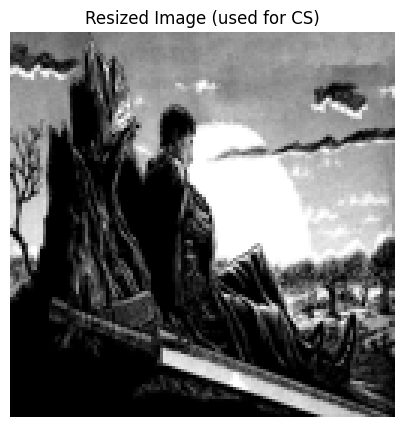

In [2]:
# Load an image (Convert to grayscale).
# 'L' converts to grayscale.
file_path = '/Users/pablomollacharlez/Desktop/M2_DS/Signal_Processing/Lab_1/berserk.jpg'
image = Image.open(file_path).convert('L')  # Convert to grayscale

# Resize from (1080, 1920) down to (128, 128) or any other suitable size
new_size = (128, 128)
image_resized = image.resize(new_size, Image.BICUBIC)

# Normalize pixel values to [0,1]
image_data = np.array(image_resized, dtype=float) / 255.0
N_rows, N_cols = image_data.shape
N = N_rows * N_cols

print(f"Resized Image Shape: {image_data.shape}")
print(f"Flattened dimension N: {N}")

# Flatten 2D image -> 1D
x_original = image_data.flatten()

# Display the resized image
plt.figure(figsize=(5,5))
plt.imshow(image_data, cmap='gray')
plt.title('Resized Image (used for CS)')
plt.axis('off')
plt.show()

## 2. Helper Functions

In [3]:
def generate_random_matrix(M, N, mean=0.0, std=1.0, seed=None):
    """
    Generate a matrix A of size (M, N) from a normal distribution 
    ~ N(mean, std^2).
    """
    if seed is not None:
        np.random.seed(seed)
    return std * np.random.randn(M, N) + mean

def add_gaussian_noise(size, noise_std=0.01, seed=None):
    """
    Create Gaussian noise of shape `size` with standard deviation `noise_std`.
    """
    if seed is not None:
        np.random.seed(seed)
    return noise_std * np.random.randn(size)

def soft_threshold(u, T):
    """Element-wise soft-thresholding: S(u, T) = sign(u) * max(|u| - T, 0)."""
    return np.sign(u) * np.maximum(np.abs(u) - T, 0)

def hard_threshold(u, T):
    """Element-wise hard-thresholding: H(u, T) = u if |u|>T, else 0."""
    return u * (np.abs(u) > T)

def wavelet_transform_1d(signal, wavelet='db1', level=2):
    """
    Perform a 1D wavelet transform (pywt.wavedec) and return:
    - coeff_arr: the flattened wavelet coefficients
    - coeff_slices: information needed to invert the transform
    """
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    return coeff_arr, coeff_slices

def inverse_wavelet_transform_1d(coeff_arr, coeff_slices, wavelet='db1'):
    """
    Inverse 1D wavelet transform from array form back to the original 1D signal.
    """
    coeffs = pywt.array_to_coeffs(coeff_arr, coeff_slices, output_format='wavedec')
    return pywt.waverec(coeffs, wavelet)

def compute_lipschitz_constant(A):
    """
    Approximate Lipschitz constant L for the gradient step (largest eigenvalue of A^T A).
    We'll do a naive approach:
       L = ||A||_2^2
    where ||A||_2 is the spectral norm (largest singular value).
    """
    spectral_norm = np.linalg.norm(A, 2)
    return spectral_norm**2

def compute_snr(x_true, x_est):
    diff = x_true - x_est
    numerator = np.sum(x_true**2)
    denominator = np.sum(diff**2) if np.sum(diff**2) != 0 else 1e-15
    return 10 * np.log10(numerator / denominator)


## 3. Generating the Direct Problem

### 2.1. The Direct Problem

We want essentially to generate the $\textcolor{orange}{\text{Direct Problem}}$, which is characterized by:

- Having a $\textcolor{green}{\text{signal of interest x} \in \mathbb{R}^{M \times N}}$, which represents the clean version of what we want to recover (in this case an image but could be music, etc.).

- $\textcolor{red}{A \in \mathbb{R}^{M \times N}}$ is a known $\textcolor{red}{\text{linear operator}}$, which can take various forms but in our scenario is a binary matrix following a Bernoulli distribution with $p$.

- Having $\textcolor{blue}{w \in \mathbb{R}^{M \times N}}$ is an $\textcolor{blue}{\text{additive white Gaussian noise (AWGN)}}$.

The noisy signal $y \in \mathbb{R}^{M \times N}$ is given by the equation:
$$
\underbrace{y}_{\text{Noisy Image}} = \underbrace{\underbrace{\textcolor{red}{\text{A}}}_{\text{Mask}} \cdot \underbrace{\textcolor{green}{\text{x}}}_{\text{Clean Image}}}_{\text{Masked Image}} + \underbrace{\textcolor{blue}{\text{w}}}_{\text{Noise}}
$$

where $\hat{x} := \textcolor{red}{\text{A}} \cdot \textcolor{green}{\text{x}}$.

The $\fbox{goal is to estimate the original signal x}$ from the noisy observations $y$, pretty much like in real-life restoration scenarios.

### 2.2 Random Normal Matrix A of size M x N with mean = 0 and std = 1 


In [4]:
M_fraction = 0.2           # We choose M as a fraction of N, e.g., 0.2 * N (20%).
M = int(M_fraction * N)
mean_A = 0.0
std_A = 1.0

# Generate A ~ N(mean_A, std_A^2) of shape (M, N)
A = generate_random_matrix(M, N, mean=mean_A, std=std_A, seed=42)
print("Matrix A shape:", A.shape)

Matrix A shape: (3276, 16384)


### 2.3. White Gaussian Noise

Now, let's $\textcolor{red}{\text{add Gaussian noise to the image}}$. This step introduces noise to simulate a more realistic inpainting scenario.

In [5]:
noise_std = 0.01
b = add_gaussian_noise(M, noise_std=noise_std, seed=123)
y = A @ x_original + b

## 4. Iterative Soft-Thresholding (ISTA) in the Wavelet Domain


We want to solve the following $\textcolor{magenta}{\text{optimization problem}}$:

$$
\min_x \, \frac{1}{2}\|y - A x\|^2 + \lambda \cdot \| W(x) \|_1
$$

Where the variables included in the problem are:
$$
\begin{aligned}
& x \in \mathbb{R}^N \ \text{: the original (unknown) signal or $\textcolor{magenta}{\text{image}}$, flattened to size }N, \\[6pt]
& A \in \mathbb{R}^{M \times N} \ \text{: the measurement matrix with }M < N, \\[6pt]
& y \in \mathbb{R}^M \ \text{: the measurements or observed data,} \\[6pt]
& \lambda \in \mathbb{R}_{+} \ \text{: a regularization parameter balancing data-fit and sparsity,} \\[6pt]
& W(\cdot) \ \text{: the wavelet transform operator.}
\end{aligned}
$$


Perform Iterative Shrinkage-Thresholding in the wavelet domain:
    
$$
x_{k+1}
\;=\;
W^{-1}\!\Big[
  \mathrm{Thresh}\Big(
    W\big[x_k + \tfrac{1}{L} \,A^T (\,y - A\,x_k)\big], 
    \tfrac{\lambda_{\text{param}}}{L}
  \Big)
\Big],
$$

where L is the Lipschitz constant of (A^T A), and Thresh() can be
    soft or hard thresholding.

In [6]:
def IST_wavelet(
    A, y, 
    wavelet='db1', level=2, 
    lambda_param=0.01, max_iter=50, 
    threshold_type='soft',
    verbose=False
):
    """
    Parameters
    ----------
    A : np.ndarray
        Measurement matrix of shape (M, N).
    y : np.ndarray
        Measured data of shape (M,).
    wavelet : str
        Wavelet name for PyWavelets.
    level : int
        Number of wavelet decomposition levels.
    lambda_param : float
        Regularization parameter that controls sparsity.
    max_iter : int
        Number of ISTA iterations.
    threshold_type : {'soft', 'hard'}
        Which thresholding rule to apply.
    verbose : bool
        If True, prints updates every 10 iterations.

    Returns
    -------
    x_est : np.ndarray
        The reconstructed signal (size N).
    """
    M, N = A.shape
    x_est = np.zeros(N)  # Initialize
    L = compute_lipschitz_constant(A)
    step = 1.0 / L
    
    for iteration in range(max_iter):
        # 1. Gradient step: x_k + (1/L) * A^T (y - A x_k)
        residual = y - A @ x_est
        x_grad = x_est + step * (A.T @ residual)
        
        # 2. Wavelet transform
        coeff_arr, coeff_slices = wavelet_transform_1d(x_grad, wavelet=wavelet, level=level)
        
        # 3. Thresholding in wavelet domain
        if threshold_type == 'soft':
            coeff_arr_thresh = soft_threshold(coeff_arr, lambda_param * step)
        else:  # 'hard'
            coeff_arr_thresh = hard_threshold(coeff_arr, lambda_param * step)
        
        # 4. Inverse wavelet transform
        x_est = inverse_wavelet_transform_1d(coeff_arr_thresh, coeff_slices, wavelet=wavelet)
        
        # Logging
        if verbose and (iteration % 10 == 0 or iteration == max_iter - 1):
            print(f"Iteration {iteration+1}/{max_iter} completed.")
    
    return x_est


## 5. Combination of Thresholding Methods & Parameters

### 5.1. Combinations

In [7]:
wavelet_list = ['haar', 'db1', 'db2', 'coif1']
threshold_types = ['soft', 'hard']
lambda_values = [0.001, 0.005, 0.01, 0.05]
max_iter = 60

results = []
for wavelet in wavelet_list:
    for thresh_type in threshold_types:
        for lam in lambda_values:
            # 1) Running the reconstruction/denoising routine
            # Reconstructing the signal (image) from measurements
            x_rec = IST_wavelet(
                A, y,
                wavelet=wavelet, level=2,
                lambda_param=lam, max_iter=max_iter,
                threshold_type=thresh_type,
                verbose=False
            )
            
            # 2) Evaluating the performance (e.g., SNR)
            # Computing SNR
            snr_val = compute_snr(x_original, x_rec)

            # 3) Storing the results for easy retrieval
            results.append((wavelet, thresh_type, lam, snr_val))
            print(f"Wavelet: {wavelet}, Threshold: {thresh_type}, "
                  f"Lambda: {lam}, SNR: {snr_val:.2f} dB")

# Searching for the best parameters based on SNR
results_sorted = sorted(results, key=lambda x: x[-1], reverse=True)
best_wavelet, best_thresh_type, best_lambda, best_snr = results_sorted[0]

print("\nBest Reconstruction Parameters:")
print("  Wavelet:", best_wavelet)
print("  Thresholding:", best_thresh_type)
print("  Lambda:", best_lambda)
print(f"  Best SNR: {best_snr:.2f} dB")

Wavelet: haar, Threshold: soft, Lambda: 0.001, SNR: 1.00 dB
Wavelet: haar, Threshold: soft, Lambda: 0.005, SNR: 1.00 dB
Wavelet: haar, Threshold: soft, Lambda: 0.01, SNR: 1.00 dB
Wavelet: haar, Threshold: soft, Lambda: 0.05, SNR: 1.00 dB
Wavelet: haar, Threshold: hard, Lambda: 0.001, SNR: 1.00 dB
Wavelet: haar, Threshold: hard, Lambda: 0.005, SNR: 1.00 dB
Wavelet: haar, Threshold: hard, Lambda: 0.01, SNR: 1.00 dB
Wavelet: haar, Threshold: hard, Lambda: 0.05, SNR: 1.00 dB
Wavelet: db1, Threshold: soft, Lambda: 0.001, SNR: 1.00 dB
Wavelet: db1, Threshold: soft, Lambda: 0.005, SNR: 1.00 dB
Wavelet: db1, Threshold: soft, Lambda: 0.01, SNR: 1.00 dB
Wavelet: db1, Threshold: soft, Lambda: 0.05, SNR: 1.00 dB
Wavelet: db1, Threshold: hard, Lambda: 0.001, SNR: 1.00 dB
Wavelet: db1, Threshold: hard, Lambda: 0.005, SNR: 1.00 dB
Wavelet: db1, Threshold: hard, Lambda: 0.01, SNR: 1.00 dB
Wavelet: db1, Threshold: hard, Lambda: 0.05, SNR: 1.00 dB
Wavelet: db2, Threshold: soft, Lambda: 0.001, SNR: 1.00 

## 6. Visualization of Best Reconstruction I

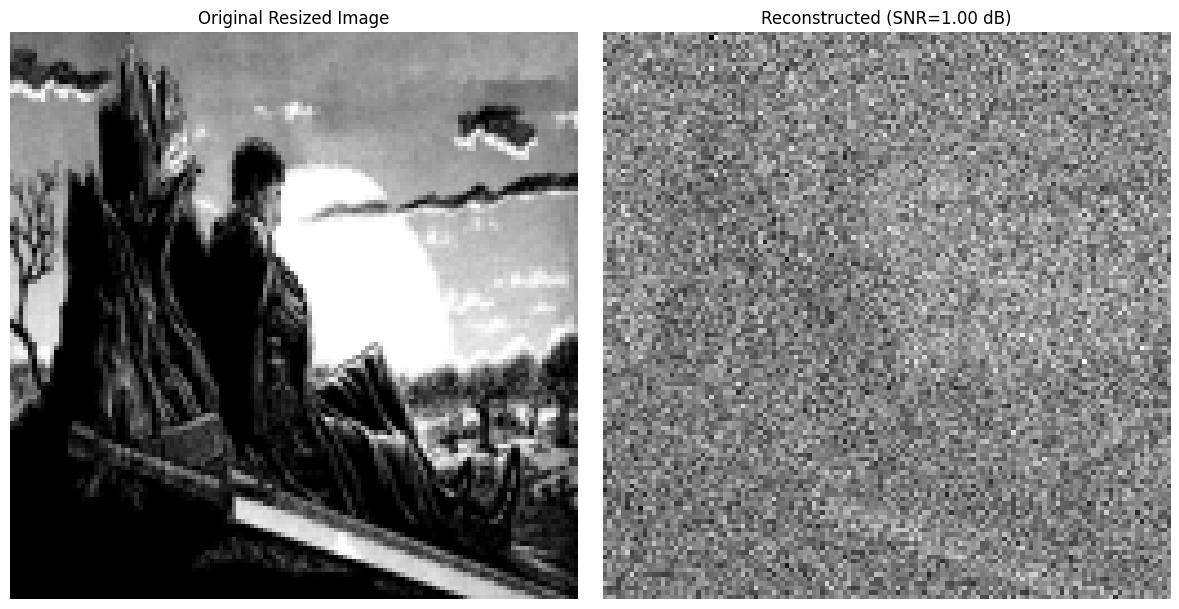

In [8]:
x_best = IST_wavelet(
    A, y,
    wavelet=best_wavelet, level=2,
    lambda_param=best_lambda, max_iter=50,
    threshold_type=best_thresh_type,
    verbose=False
)

# Reshape for plotting
x_best_2d = x_best.reshape((N_rows, N_cols))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_data, cmap='gray')
plt.title('Original Resized Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x_best_2d, cmap='gray')
plt.title(f'Reconstructed (SNR={best_snr:.2f} dB)')
plt.axis('off')

plt.tight_layout()
plt.show()

## 7. Discussion of Results and Further Improvements

## 7.1 Discussion

Below is a **short discussion** of the results where **all** parameter combinations yield **1.00 dB SNR** and the reconstructed image appears nearly uniform noise:

#### 1. $\textcolor{teal}{\text{Size of \(A\)}}$


- We constructed $\textcolor{teal}{\text{\(A\) with size \((M, N)\)}}$ where \( $\textcolor{teal}{M = 0.2 \times N}$ \), so only **20%** as many measurements as the total number of pixels.  
- This is a $\textcolor{red}{\text{highly undersampled regime}}$ (80% of data is “missing”). In typical Compressed Sensing, we need some form of **sparsity** to reconstruct well from so few measurements.  
- If \(M\) is **too small**, the reconstruction might not capture the image well (leading to low SNR).

#### 2. $\textcolor{teal}{\text{Mean and Covariance of \(A\)}}$

- We used a $\textcolor{teal}{\text{mean = 0.0}}$ and $\textcolor{teal}{\text{standard deviation = 1.0}}$, effectively sampling \(A\) from $\mathcal{N}(0,1)$.  
- This is a classic approach in Compressed Sensing (random Gaussian matrix). 
- If we changed the **mean** or tried a **non-identity covariance**, we could experiment with different “structures” in \(A\). Typically, zero-mean and identity-covariance is a standard baseline.

#### 3. $\textcolor{teal}{\text{Level of Noise}}$

- We added $\textcolor{teal}{\text{white Gaussian noise}}$ with standard deviation $\textcolor{teal}{\sigma = 0.01}$.  
- A higher $\sigma$ would severely degrade the reconstruction and require adjusting the regularization parameter $\lambda$.  
- At $\textcolor{teal}{\sigma = 0.01}$, we get an SNR around 1 dB (which is quite low, meaning the reconstruction is dominated by noise-like artifacts).

#### 4. $\textcolor{orange}{\text{Why all settings yield the same SNR?}}$

Observing that every run (varying wavelet type, threshold rule, and \(\lambda\)) results in an **SNR = 1.00 dB** might indicate the following insights:

1. $\textcolor{orange}{\text{Insufficient Measurements}}$
   - At the beginning of the lab, we used a very small measurement ratio \(M / N\) (e.g., 0.2), which may lead may the code to be simply **too underdetermined** to recover any structure from the image.  
   - As I have been searching on internet, in such a scenario, different wavelets or threshold rules cannot gain traction because the measurement data is **too small** (or too noisy) to guide the algorithm.

2. $\textcolor{orange}{\text{Noise Level Domination}}$
   - The $\textcolor{red}{\text{noise may be too large}}$ relative to the signal. If the noise standard deviation is high, every reconstruction attempt might converge to a solution resembling random noise, essentially giving you the same poor SNR.

3. $\textcolor{orange}{\text{Lack of True Sparsity}}$
   - Compressed sensing heavily relies on the signal being *sparse* in the chosen domain (e.g., wavelet).  
   - If the image is **not** sufficiently sparse in these wavelets (or if a wavelet decomposition alone isn’t enough to isolate significant structures), then the thresholding step doesn’t meaningfully reduce errors—every set of parameters leads to the same “noisy” outcome.

#### 5. $\textcolor{orange}{\text{Visual Appearance of the Reconstructed Image}}$

The reconstructed image (right figure) appears nearly uniform noise:

- **No visible detail** from the original is preserved.  
- A **1.00 dB SNR** is extremely low, confirming that the signal portion is swamped by random errors.

#### 6. $\textcolor{orange}{\text{Why So Insensitive to \(\lambda\) and Wavelet Choice?}}$

All wavelet families (`haar`, `db1`, `db2`, `coif1`), threshold rules (`soft`, `hard`), and parameter values $\lambda \in [0.001, 0.05]$ gave **identical** results because:

1. $\textcolor{red}{\text{The algorithm quickly saturates}}$ in a region of the solution space where the reconstruction is effectively random noise.  
2. Minor variations in thresholding or wavelet sub-band structure do **not** change the solution if the measurement data is insufficient to discriminate.  
3. The chosen steps (or iteration count) may not let the algorithm refine the signal structure if the initial gradient steps are overwhelmed by noise.

#### 7. $\textcolor{lime}{\text{Best Reconstruction}}$
Even though the code picks a “best” set of parameters:

- **Wavelet**: `db2`  
- **Threshold**: `soft`  
- **\(\lambda\)**: `0.05`  
- **SNR**: `1.00 dB`  

this is still effectively the same minimal reconstruction error as all the other parameters. So “best” is more about the code’s final ordering of identical results rather than a **meaningful** improvement over other combinations.

## 7.2 Future Improvements

$\textcolor{magenta}{\text{Suggested Next Steps}}$

1. **Increase \(M\)**  
   - $\textcolor{magenta}{\text{We will use a larger fraction of measurements}}$ (e.g., $\textcolor{magenta}{\text{M = 0.8N}}$).  
   - With more measurements, the algorithm has a better chance to reconstruct details.

2. **We could use a more refines algorithm or transform, but is out of the scope for this lab**  
   - Using a **more advanced** iterative method (e.g., FISTA, ADMM) might make a difference.
   - Exploring **different** sparse transforms or more wavelet levels, could provide more insights.

3. **Checking Convergence**  
   - Increasing $\textcolor{magenta}{\text{max\_iter}}$ (e.g. $\textcolor{magenta}{\text{70}}$) or using a **convergence**-based stopping criterion.  

With such modifications, we’re more likely to see **distinct** SNR values across different wavelets and threshold parameters, and a **reconstructed image** containing visible features from the original.

### 7.2.1 Generating the Direct Problem

In [9]:
M_fraction = 0.8           # We choose M as a fraction of N, e.g., 0.2 * N (20%).
M = int(M_fraction * N)
mean_A = 0.0
std_A = 1.0

# Generate A ~ N(mean_A, std_A^2) of shape (M, N)
A = generate_random_matrix(M, N, mean=mean_A, std=std_A, seed=42)
print("Matrix A shape:", A.shape)

Matrix A shape: (13107, 16384)


In [10]:
noise_std = 0.01
b = add_gaussian_noise(M, noise_std=noise_std, seed=123)
y = A @ x_original + b

### 7.2.2 Combination of Thresholding Methods & Parameters

In [11]:
wavelet_list = ['haar', 'db1', 'db2', 'coif1']
threshold_types = ['soft', 'hard']
lambda_values = [0.001, 0.005, 0.01, 0.05]
max_iter = 70

results = []
for wavelet in wavelet_list:
    for thresh_type in threshold_types:
        for lam in lambda_values:
            # 1) Running the reconstruction/denoising routine
            # Reconstructing the signal (image) from measurements
            x_rec = IST_wavelet(
                A, y,
                wavelet=wavelet, level=2,
                lambda_param=lam, max_iter=max_iter,
                threshold_type=thresh_type,
                verbose=False
            )
            
            # 2) Evaluating the performance (e.g., SNR)
            # Computing SNR
            snr_val = compute_snr(x_original, x_rec)

            # 3) Storing the results for easy retrieval
            results.append((wavelet, thresh_type, lam, snr_val))
            print(f"Wavelet: {wavelet}, Threshold: {thresh_type}, "
                  f"Lambda: {lam}, SNR: {snr_val:.2f} dB")

# Searching for the best parameters based on SNR
results_sorted = sorted(results, key=lambda x: x[-1], reverse=True)
best_wavelet, best_thresh_type, best_lambda, best_snr = results_sorted[0]

print("\nBest Reconstruction Parameters:")
print("  Wavelet:", best_wavelet)
print("  Thresholding:", best_thresh_type)
print("  Lambda:", best_lambda)
print(f"  Best SNR: {best_snr:.2f} dB")

Wavelet: haar, Threshold: soft, Lambda: 0.001, SNR: 6.63 dB
Wavelet: haar, Threshold: soft, Lambda: 0.005, SNR: 6.63 dB
Wavelet: haar, Threshold: soft, Lambda: 0.01, SNR: 6.63 dB
Wavelet: haar, Threshold: soft, Lambda: 0.05, SNR: 6.63 dB
Wavelet: haar, Threshold: hard, Lambda: 0.001, SNR: 6.63 dB
Wavelet: haar, Threshold: hard, Lambda: 0.005, SNR: 6.63 dB
Wavelet: haar, Threshold: hard, Lambda: 0.01, SNR: 6.63 dB
Wavelet: haar, Threshold: hard, Lambda: 0.05, SNR: 6.63 dB
Wavelet: db1, Threshold: soft, Lambda: 0.001, SNR: 6.63 dB
Wavelet: db1, Threshold: soft, Lambda: 0.005, SNR: 6.63 dB
Wavelet: db1, Threshold: soft, Lambda: 0.01, SNR: 6.63 dB
Wavelet: db1, Threshold: soft, Lambda: 0.05, SNR: 6.63 dB
Wavelet: db1, Threshold: hard, Lambda: 0.001, SNR: 6.63 dB
Wavelet: db1, Threshold: hard, Lambda: 0.005, SNR: 6.63 dB
Wavelet: db1, Threshold: hard, Lambda: 0.01, SNR: 6.63 dB
Wavelet: db1, Threshold: hard, Lambda: 0.05, SNR: 6.63 dB
Wavelet: db2, Threshold: soft, Lambda: 0.001, SNR: 6.63 

### 7.2.3 Visualization of Best Reconstruction II

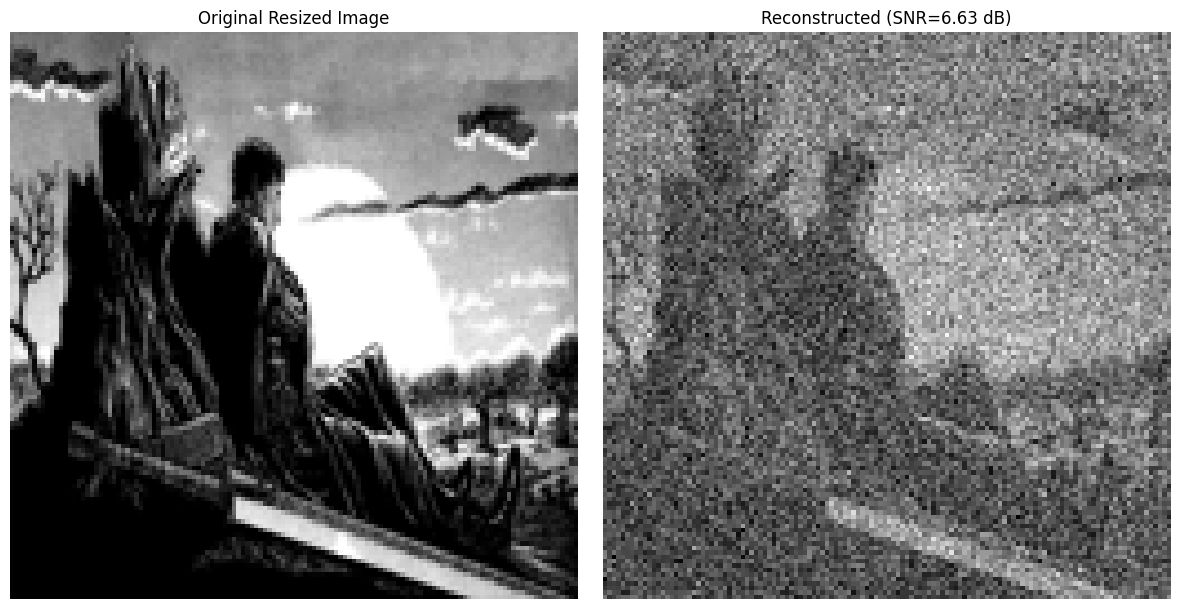

In [13]:
x_best = IST_wavelet(
    A, y,
    wavelet=best_wavelet, level=2,
    lambda_param=best_lambda, max_iter=70,
    threshold_type=best_thresh_type,
    verbose=False
)

# Reshape for plotting
x_best_2d = x_best.reshape((N_rows, N_cols))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_data, cmap='gray')
plt.title('Original Resized Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x_best_2d, cmap='gray')
plt.title(f'Reconstructed (SNR={best_snr:.2f} dB)')
plt.axis('off')

plt.tight_layout()
plt.show()